## 컨볼루션 네트워크 기반 EEG신호 분석


<img src="https://drive.google.com/uc?id=1gHeduLjq4hnBfKuQdbejfSELIyWnvgUO" width="750" height="350">



## **Dataset**

### **Motor Imagery EEG** 
BCI Competition IV-IIa dataset \\
http://www.bbci.de/competition/iv/#dataset2a/ \\
4 class motor imagery (Left hand, Right hand, Feet, and Tongue) \\
9 subjects, 72 trials per each class, 2 sessions for each subject \\
22 Ag/AgCl electrode channels, 0.5~50Hz band-pass filtering \\
250Hz sampling

##** Preprocessing**
실험의 편의를 위해 1번 subject의 Left hand, Right hand의 두 가지 class만 가져와서 사용 \\
Fixation cross, resting state signal의 평균값을, motor imagery의 cue에서 빼줌


## **Library Download**

In [2]:
import tensorflow as tf
import numpy as np
!pip install mne # To plot topography
from mne.viz import plot_topomap
from mne.channels import read_montage
from mne import EvokedArray, create_info
import matplotlib.pyplot as plt

In [0]:
# Dataset download
!wget -nc -q https://github.com/ku-milab/Neuroimage-Analysis-Tutorial/raw/master/data/A01T.npy
!wget -nc -q https://github.com/ku-milab/Neuroimage-Analysis-Tutorial/raw/master/data/A01E.npy
!wget -nc -q https://github.com/ku-milab/Neuroimage-Analysis-Tutorial/raw/master/data/A01E_label.npy
!wget -nc -q https://github.com/ku-milab/Neuroimage-Analysis-Tutorial/raw/master/data/w.npy
!wget -nc -q https://github.com/ku-milab/Neuroimage-Analysis-Tutorial/raw/master/data/conv_input_class1.npy
!wget -nc -q https://github.com/ku-milab/Neuroimage-Analysis-Tutorial/raw/master/data/conv_output_class1.npy
!wget -nc -q https://github.com/ku-milab/Neuroimage-Analysis-Tutorial/raw/master/data/conv_input_class2.npy
!wget -nc -q https://github.com/ku-milab/Neuroimage-Analysis-Tutorial/raw/master/data/conv_output_class2.npy

In [9]:
!ls

A01E_label.npy	conv_input_class1.npy	datalab			   nilearn_data
A01E.npy	conv_input_class2.npy	KHBM_ADNI_eMCINC_ERES.mat  w.npy
A01T.npy	conv_output_class1.npy	log
colab_utils	conv_output_class2.npy	ngrok


In [0]:
## Define moduels
def load_data(train):
    if train == True:
        data = np.load("./A01T.npy") # (22, 750, 144)
        label = np.zeros(shape=(72))
        label = np.concatenate((label, label+1), 0) # (144,)
        return data, label
    else:
        data = np.load("./A01E.npy") # (22, 750, 144)
        label = np.load("./A01E_label.npy") # (144,)
        return data, label

def get_params(name, shape):
    w = tf.get_variable(name=name + "w", shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                        dtype=tf.float32)
    n_filter = shape[-1]
    b = tf.Variable(name=name + "b", initial_value=tf.constant(0.1, shape=[n_filter], dtype=tf.float32))
    return w, b

def conv(input, w, b):
    conv = tf.nn.conv2d(input=input, filter=w, strides=(1, 1, 1, 1), padding="VALID")
    return tf.nn.bias_add(conv, b)

def max_pool(input):
    return tf.nn.max_pool(value=input, ksize=(1, 1, 3, 1), strides=(1, 1, 3, 1), padding="VALID")

def lin_map(input, name, num_output):
    num_input = input.get_shape().as_list()[-1]
    w, b = get_params(name=name, shape=(num_input, num_output), n_filter=num_output)
    logit = tf.nn.bias_add(tf.matmul(input, w), b)
    return logit, tf.nn.sigmoid(logit)

def batchnorm(input):
    return tf.nn.batch_normalization(x=input, mean=0, variance=1, offset=None, scale=None, variance_epsilon=1e-8)

def dropout(input, keep_prob):
    return tf.nn.dropout(x=input, keep_prob=keep_prob)
  
def calc_acc(label, prediction):
  acc = 0
  for i in range(label.shape[0]):
    if label[i] == prediction[i]:
      acc = acc + 1
  acc = acc/label.shape[0]
  return acc

## **Deep ConvNet**

<img src="https://drive.google.com/uc?id=1r8yjdKVRwhoUP6B-RC3ICBOiOpIGGGZ6" width="350" height="500">




In [0]:
## Assemble Deep ConvNet (Schirrmeister et al., HBM, 2017)
def deepconv(input, keep=0.5, reuse=None):
    with tf.variable_scope("deepconv") as scope:
        if reuse:
            scope.reuse_variables()
            keep = 1.0

        # 1st Temporal Convolution, Linear activation
        w1, b1 = get_params(name="conv1", shape=(1, 10, 1, 25), n_filter=25)
        conv1 = conv(input=input, w=w1, b=b1) # (32, 22, 503, 25)

        # 2nd Spatial Convolution, ELU activation, Max pooling
        w2, b2 = get_params(name="conv2", shape=(22, 1, 25, 25), n_filter=25)
        conv2 = conv(input=conv1, w=w2, b=b2)
        conv2_ap = conv2
        conv2 = batchnorm(conv2)
        conv2 = tf.nn.elu(conv2)
        conv2 = max_pool(conv2)
        conv2 = dropout(conv2, keep) # (32, 1, 167, 25)

        # 3rd Temporal Convolution, ELU activation, Max pooling
        w3, b3 = get_params(name="conv3", shape=(1, 10, 25, 50), n_filter=50)
        conv3 = conv(input=conv2, w=w3, b=b3)
        conv3 = batchnorm(conv3)
        conv3 = tf.nn.elu(conv3)
        conv3 = max_pool(conv3)
        conv3 = dropout(conv3, keep) # (32, 1, 52, 50)

        # 4th Temporal Convolution, ELU activation
        w4, b4 = get_params(name="deep4", shape=(1, 10, 50, 100), n_filter=100)
        conv4 = conv(input=conv3, w=w4, b=b4)
        conv4 = batchnorm(conv4)
        conv4 = tf.nn.elu(conv4)
        conv4 = max_pool(conv4)
        conv4 = dropout(conv4, keep) # (32, 1, 14, 100)

        # 5th Temporal Convolution, ELU activation
        w5, b5 = get_params(name="deep5", shape=(1, 10, 100, 200), n_filter=200)
        conv5 = conv(input=conv4, w=w5, b=b5)
        conv5 = batchnorm(conv5)
        conv5 = tf.nn.elu(conv5)
        conv5 = max_pool(conv5)
        conv5 = dropout(conv5, keep) # (32, 1, 1, 200)

        # Linear Mapping
        batch = conv5.get_shape().as_list()[0]
        conv5 = tf.reshape(conv5, shape=(batch, -1)) # (32, 200)
        logit, output = lin_map(input=conv5, name="output", num_output=2) # (32, 2), (32, 2)
    return logit, output, w2, conv1, conv2_ap

In [10]:
## Experiment
# Load dataset
train_data, train_label = load_data(train=True) # (22, 750, 144), (144,)
print("Train data shape:", train_data.shape)
print("Train label shape:", train_label.shape)
test_data, test_label = load_data(train=False) # (22, 750, 144), (144,)

Train data shape: (22, 750, 144)
Train label shape: (144,)


In [0]:
# Define hyperparameters
batch_size = 32
num_channel = 22
window_size = 512
rest_point = train_data.shape[-2] - window_size + 1 # 239
num_class = 2
num_trials = train_data.shape[-1] # 144
num_timepoints = train_data.shape[1] # 750
total_epoch = 4

In [0]:
# Placeholding
X = tf.placeholder(dtype=tf.float32, shape=(batch_size, num_channel, window_size, 1))
Y = tf.placeholder(dtype=tf.float32, shape=(batch_size))
X_test = tf.placeholder(dtype=tf.float32, shape=(rest_point , num_channel, window_size, 1)) # For test

In [0]:
# Extract logit and output
logit, _, _, _, _ = deepconv(input=X)
_, pred, _, _, _ = deepconv(input=X_test, reuse=True) # For test
# _, _, w, conv_input, conv_output = deepconv(input=X, reuse=True) # For analysis

In [0]:
# Calculate loss
label = tf.one_hot(tf.cast(Y, tf.int64), depth=2) # One-hot encoding
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=logit))

# Call parameters
parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="deepconv")

# Build an Adam-optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, var_list=parameters)

In [0]:
## Open Tensorflow session
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

# Call model saver
saver = tf.train.Saver(keep_checkpoint_every_n_hours=8, max_to_keep=100)

In [18]:
## Model training
print("Begin Training")
total_batch = int((rest_point * num_trials) / batch_size)  # int(34416/32)
for epoch in range(total_epoch):
    # Randomize the training dataset
    rand_idx = np.random.permutation(rest_point * num_trials) # 34416
    for batch in range(total_batch):
        batch_x = np.empty(shape=(batch_size, num_channel, window_size, 1))
        batch_y = np.empty(shape=batch_size)
        for pos in range(batch_size):
          #position 대충설명
            position = np.unravel_index(indices=rand_idx[batch * batch_size + pos], dims=(rest_point, num_trials))
            batch_x[pos, :, :, :] = np.expand_dims(train_data[:, position[0]:position[0]+window_size, position[1]], axis=-1)
            batch_y[pos] = train_label[position[1]]

        # Feed dictionary
        _, loss_ = sess.run([optimizer, loss], feed_dict={X: batch_x, Y: batch_y})
    print("%dth Epoch Training Loss: %f" %(epoch + 1, loss_))
print("Model Saving")
saver.save(sess, "./model.ckpt")
print("End Training\n")

Begin Training
1th Epoch Training Loss: 0.717271
2th Epoch Training Loss: 0.294816
3th Epoch Training Loss: 0.171875
4th Epoch Training Loss: 0.138661
Model Saving
End Training



In [0]:
# Model test
print("Begin Test")
print("Model Restoring")
saver.restore(sess, "./model.ckpt")
prediction = np.empty(shape=(num_trials))
for trial in range(num_trials):
    batch_x_test = np.empty(shape=(rest_point, num_channel, window_size, 1))
    for i in range(rest_point):
        batch_x_test[i, :, :, :] = np.expand_dims(test_data[:, i:i+window_size, trial], axis=-1)
    pred_ = sess.run([pred], feed_dict={X_test:batch_x_test})
    pred_ = np.argmax(np.bincount(np.squeeze(np.argmax(np.asarray(pred_), -1)), minlength=2))
    prediction[trial] = pred_

print("Binary Class Test Accuracy: %4f" % (calc_acc(label=test_label, prediction=prediction)))
print("End Test\n")

Begin Test
Model Restoring
INFO:tensorflow:Restoring parameters from ./model.ckpt


## **Activation Pattern** (Haufe *et al*., *NeuroImage*, 2014)

## $$A\equiv\Sigma_x W\Sigma_{\hat{s}}^{-1}$$
### $A$: Activation pattern 
### $W$: Learned filters
### $\Sigma_x$: Covariance of filter inputs
### $\Sigma_{\hat{s}}$: Covariance of filter outputs

<img src="https://drive.google.com/uc?id=1uj-Bzl_JB7owQRCfJTIFBYWSeVMR4vry" width="350" height="200">





In [0]:
# Load learned spatial weight vectors, inputs, and outputs
w = np.load("./w.npy")
class1_input = np.load("./conv_input_class1.npy")
class1_output = np.load("./conv_output_class1.npy")
class2_input = np.load("./conv_input_class2.npy")
class2_output = np.load("./conv_output_class2.npy")

# To calculate activation pattern, reshaping matrices
w = np.reshape(w, newshape=(22, 1, -1))
class1_input = np.moveaxis(class1_input, 0, -1)
class1_output = np.moveaxis(class1_output, 0, -1)
class2_input = np.moveaxis(class2_input, 0, -1)
class2_output = np.moveaxis(class2_output, 0, -1)

# Calculate mean of covariance of inputs and outputs
class1_input = np.mean(np.reshape(class1_input, (22, 14, -1)), -1)
class1_output = np.mean(np.reshape(class1_output, (1, 1, -1)), -1)
class2_input = np.mean(np.reshape(class2_input, (22, 14, -1)), -1)
class2_output = np.mean(np.reshape(class2_output, (1, 1, -1)), -1)

# Calculate Activation Pattern
class1_activation_pattern = np.empty(shape=w.shape)
class2_activation_pattern = np.empty(shape=w.shape)
for i in range(class1_activation_pattern.shape[-1]):
    class1_activation_pattern[:, :, i] = np.matmul(np.cov(class1_input), w[:, :, i]) * 1/np.squeeze(class1_output)
    class2_activation_pattern[:, :, i] = np.matmul(np.cov(class2_input), w[:, :, i]) * 1/np.squeeze(class2_output)

# Save Activation Pattern
np.save("./class1_ap.npy", class1_activation_pattern)
np.save("./class2_ap.npy", class2_activation_pattern)

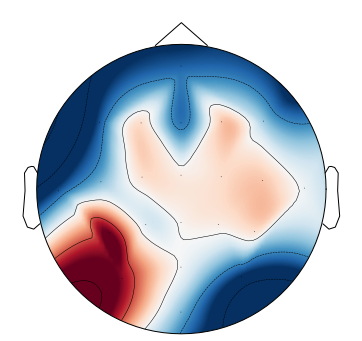

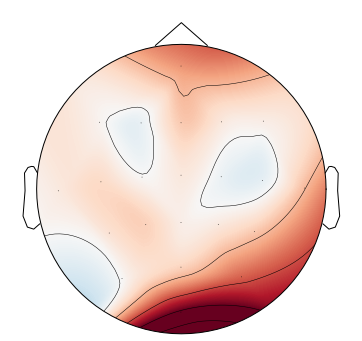

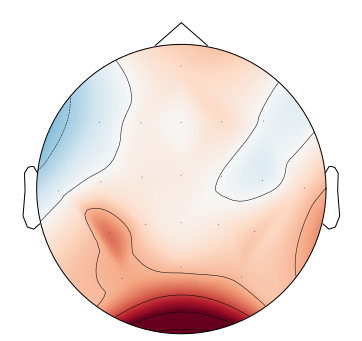

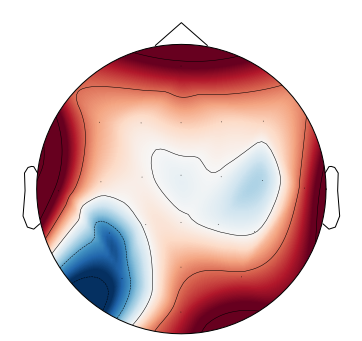

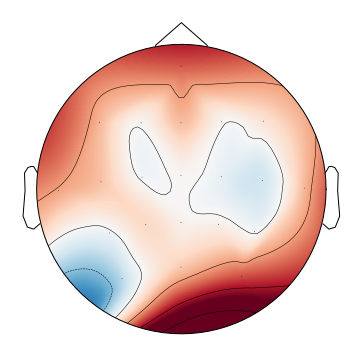

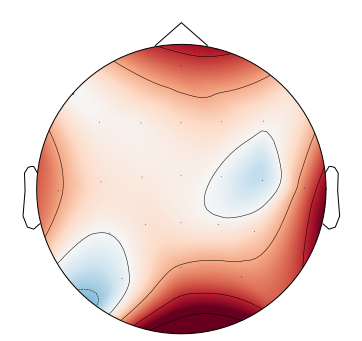

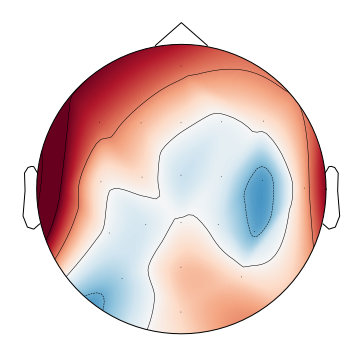

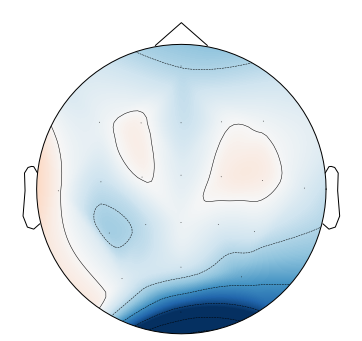

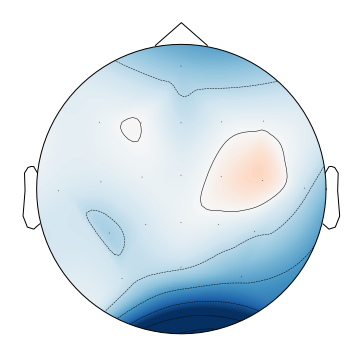

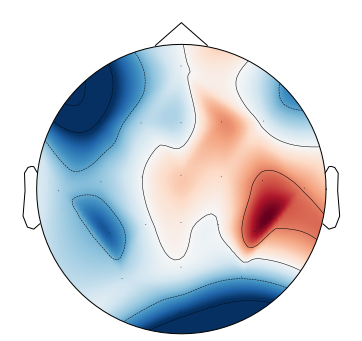

In [22]:
# Load Activation Patterns
ap_1 = np.load("./class1_ap.npy")
ap_1 = np.squeeze(ap_1)

# Inform channel information
channel = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1',
           'CPz', 'CP2', 'CP4', 'P3', 'Pz', 'P4', 'POz']
montage = read_montage(kind="standard_1020")
info = create_info(ch_names=channel, sfreq=250, ch_types="eeg", montage=montage)
evoked = EvokedArray(data=ap_1, info=info, tmin=0.)

for num in range(10):
    plot_topomap(data=ap_1[:, num], pos=evoked.info, show=True)
#     plt.savefig("./topo/%02d.png" %num)
    plt.close()